# check data

In [1]:
import os
from glob import glob
from scipy.io import wavfile
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display

In [2]:
data = glob('/Users/chienan/job/text2speech/competition/data/wav/*')

In [3]:
with open('/Users/chienan/job/text2speech/competition/data/text.txt', 'r') as f:
    lines = [line.strip("\r\n ") for line in f]

In [4]:
sr, wav = wavfile.read(data[1])

In [5]:
S = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=128,fmax=8000)

In [6]:
s = librosa.power_to_db(S,ref=np.max)

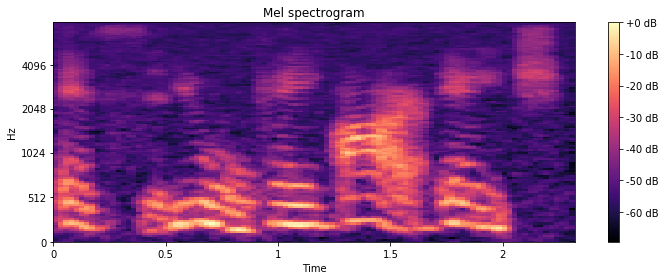

In [7]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

# create dataset

In [8]:
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
import lmdb
import six
import sys
from PIL import Image
import numpy as np
from scipy import signal

In [9]:
char_dict = {'2':0, '3':1, '4':2, '5':3, '6':4, '7':5, '8':6, '9':7, 
         'A':8, 'B':9, 'C':10, 'D':11, 'E':12, 'F':13, 'G':14, 'H':15, 'J':16, 'K':17, 'N':18, 'P':19, 'Q':20,
         'R':21, 'S':22, 'T':23, 'U':24, 'V':25, 'X':26, 'Y':27, 'Z':28}

In [10]:
''.join(list(char_dict.keys()))

'23456789ABCDEFGHJKNPQRSTUVXYZ'

In [11]:
database = lmdb.open('/Users/chienan/job/text2speech/competition/data/dataset',map_size=1073741824)

In [12]:
data = glob('/Users/chienan/job/text2speech/competition/data/wav/*')

In [13]:
with database.begin(write=True) as db:
    for ind, d in enumerate(data):
        sr, wav = wavfile.read(d)
        f, t, Sxx = signal.spectrogram(wav, sr)
        Sxx = Sxx[:50,:] # 低頻的才是重點，高頻多為雜訊
        db.put(key='input-%05d'.encode()%(ind+1),
               value=Sxx.astype(np.float64).tobytes())
        db.put(key='label-%05d'.encode()%(ind+1),
               value=d.split('/')[-1][:-4].encode())

In [14]:
env = lmdb.open('/Users/chienan/job/text2speech/competition/data/dataset',
                max_readers=1,
                readonly=True,
                lock=False,
                readahead=False,
                meminit=False)

In [15]:
with env.begin(write=False) as txn:
    img_key = 'input-%05d'.encode()%1
    label_key = 'label-%05d'.encode()%1
    inputbuf = txn.get(img_key)
    label = txn.get(label_key)

In [16]:
np.frombuffer(inputbuf, dtype=np.float64)

array([6.81168428e-10, 1.08828041e-09, 1.93156147e-09, ...,
       5.08440975e-09, 7.73182586e-09, 1.52794866e-08])

In [19]:
label.decode()

'BY6GT'